<a href="https://colab.research.google.com/github/silprosa/fynesse_mlfc/blob/main/proj/Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%capture
%pip install osmnx


In [2]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
import numpy as np
import math
import seaborn
import pandas
import geopandas as gpd
import numpy
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')


In [3]:

import shutil
shutil.rmtree("/content/fynesse_mlfc", ignore_errors=True)
!git clone https://github.com/silprosa/fynesse_mlfc.git
import os, subprocess, importlib, sys
sys.path.append("/content/fynesse_mlfc")
import fynesse
from fynesse import access, assess, address

Cloning into 'fynesse_mlfc'...
remote: Enumerating objects: 451, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 451 (delta 23), reused 8 (delta 8), pack-reused 414 (from 4)
Receiving objects: 100% (451/451), 3.53 MiB | 7.84 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')
household = pd.read_stata('/content/drive/MyDrive/knhs/Household_Information_Data.dta')
individual = pd.read_stata('/content/drive/MyDrive/knhs/Individual_Data.dta')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Understanding the data**
**individual data**

this data contains 80889 individuals in  21347 households




In [5]:
display(len(individual))
display(len(individual['interview__key'].unique()))
display(len(individual['interview__id']))
display(len(individual['interview__id'].unique()))


80889

21347

80889

21347

In [6]:
individual.iloc[8000:80010]

,interview__key,interview__id,a01,hhid__id,b02_1,b03,b03_other,b04,b05_years,b05_yrofbirth,...,ken_edu_attendance,edu_attendance,birthplace,relationship_details,mrts_details,age_dep,hhsize,size,wap,age_group
8000,90-59-05-73,65Abedf5C3704D6B9Bf57C7B22De0959,Taita-Taveta,3,Yes,SON OR DAUGHTER,,Male,11,2013.0,...,1 - Attending,Primary education,1 - Native-born,3 - Child / Son / Daughter,NaN,0-14,5.0,5-6 persons,1.0,Age 5-11
8001,60-22-60-35,A623Fdc571474B898D45Fb7Ed04F4C0B,Taita-Taveta,5,Yes,SON OR DAUGHTER,,Male,14,2010.0,...,1 - Attending,Primary education,1 - Native-born,3 - Child / Son / Daughter,NaN,0-14,9.0,9-10 persons,1.0,Age 12-14
8002,78-56-88-71,A85A774E2Fca4D4391440392297E2Ff1,Taita-Taveta,4,Yes,SON OR DAUGHTER,,Male,14,2009.0,...,1 - Attending,Secondary Education,1 - Native-born,3 - Child / Son / Daughter,NaN,0-14,5.0,5-6 persons,1.0,Age 12-14
8003,60-22-60-35,A623Fdc571474B898D45Fb7Ed04F4C0B,Taita-Taveta,3,Yes,SON OR DAUGHTER,,Male,19,2004.0,...,2 - Not attending,Secondary Education,1 - Native-born,3 - Child / Son / Daughter,NEVER MARRIED,15-64,9.0,9-10 persons,1.0,NaN
8004,37-58-68-13,861Fb4B81Bc947C69Db1A33Af4Db1Af2,Taita-Taveta,4,Yes,SON OR DAUGHTER,,Male,15,2009.0,...,1 - Attending,Primary education,1 - Native-born,3 - Child / Son / Daughter,NEVER MARRIED,15-64,4.0,3-4 persons,1.0,Age 15-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80005,15-84-23-67,0F886Ffaad1F46Fdb802639E71A6E2Ae,Nairobi City,1,Yes,HEAD,,Female,22,2002.0,...,1 - Attending,Middle level college,1 - Native-born,1 - Reference person / Head,NEVER MARRIED,15-64,2.0,1-2 persons,1.0,NaN
80006,62-91-56-59,3Afcd1E95A614B4Eb3981A48E5B54Fe6,Nairobi City,3,No,SON OR DAUGHTER,,Female,23,2001.0,...,1 - Attending,Bachelor's or equivalent level,1 - Native-born,3 - Child / Son / Daughter,NEVER MARRIED,15-64,5.0,5-6 persons,1.0,NaN
80007,23-07-02-83,37C8Ae0Ddc884E0C8Ba306561C8Dae7A,Nairobi City,2,Yes,NEPHEW/NIECE,,Female,21,2002.0,...,1 - Attending,Middle level college,1 - Native-born,7 NEPHEW/NIECE,NEVER MARRIED,15-64,3.0,3-4 persons,1.0,NaN
80008,97-95-47-66,5D92D117B6324Dec92Ec818Ffe9Bdadd,Nairobi City,3,Yes,SON OR DAUGHTER,,Female,20,2003.0,...,1 - Attending,Middle level college,1 - Native-born,3 - Child / Son / Daughter,NEVER MARRIED,15-64,4.0,3-4 persons,1.0,NaN


In [7]:
individual.iloc[:,34:49]

,b13_other,b13_1,b13_2,b13_2_other,b13_3,b13_4,b13_5,b14_1,b14_2,b14_3,b14_4,b02_length,inw,dif_sight,dif_hear
0,,NaN,NaN,,NaN,NaN,NaN,No,No,No,No,6.0,983.762817,No - no difficulty,No - no difficulty
1,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1243.113892,No - no difficulty,No - no difficulty
2,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,786.825134,No - no difficulty,No - no difficulty
3,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,880.786865,No - no difficulty,No - no difficulty
4,,9000.0,School bus,,15.0,Per Term,20000.0,No,Yes,Yes,Yes,5.0,1184.576782,No - no difficulty,No - no difficulty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80884,,NaN,NaN,,NaN,NaN,NaN,Yes,NaN,Yes,No,1.0,606.926636,Yes - a lot of difficulty,No - no difficulty
80885,,NaN,NaN,,NaN,NaN,NaN,Yes,NaN,Yes,Yes,2.0,1733.665039,No - no difficulty,No - no difficulty
80886,,NaN,NaN,,NaN,NaN,NaN,Yes,NaN,Yes,Yes,1.0,1250.435181,No - no difficulty,No - no difficulty
80887,,NaN,NaN,,NaN,NaN,NaN,Yes,NaN,Yes,Yes,2.0,2883.901855,No - no difficulty,No - no difficulty


In [8]:
household.head()

,interview__key,interview__id,a01,countycode,a07_1,serial,a12,c01_1,c01_1other,c01_2,...,med_prop,med_brms,hhweight,tag,internet,year_occ,pln,sf,duration,bf
0,00-00-55-14,8a585d4dd71641b8a1348be6cc11e121,Laikipia,31,Urban,35312800,6,PUBLIC WATER COMPANIES,,PIPED TO YARD/PLOT,...,NaN,NaN,182.414370,1,1.0,NaN,NaN,NaN,NaN,Electrical Engineer
1,00-01-22-52,d155c88b64de40148cda8dd079c36baa,Embu,14,Urban,44136136,3,PUBLIC WATER COMPANIES,,PIPED INTO DWELLING,...,0.2,NaN,199.056467,1,1.0,1 to 10 YEARS,NaN,NaN,NaN,NaN
2,00-02-11-67,b511ae4612704d9b9d395c901d975644,Vihiga,38,Urban,99694240,7,WATER FROM SPRING (Protected),,FETCHED BY HOUSEHOLD,...,NaN,NaN,142.092291,1,1.0,NaN,NaN,NaN,NaN,NaN
3,00-02-70-91,e1ff2d92960947d8adc30f55ff666b15,Garissa,07,Rural,92351040,6,DUG WELL (Unprotected),,FETCHED BY HOUSEHOLD,...,NaN,NaN,337.176211,1,NaN,NaN,NaN,NaN,2 to 3 years,NaN
4,00-02-78-46,522414c7575543ddb88782491aa5e190,Embu,14,Urban,26181404,4,PUBLIC WATER COMPANIES,,PIPED INTO DWELLING,...,0.2,3.0,183.463710,1,NaN,1 to 10 YEARS,NaN,NaN,NaN,NaN


Extract relevant features from the individual dataset i.e identifier,age,gender...

In [9]:
df = []
df = (
    individual[["interview__key", "interview__id", "a01","hhid__id", "b04","b05_years", "b10", "b11", "b12", "b13", "b13_1","b13_2","b13_3","b13_4","edu_attendance"]].copy()
    .rename(
        columns={
            "interview__key": "interview_key",
            "interview__id": "interview_id",
            "b04": "gender",
            "hhid__id": "household_id",
            "b05_years": "age",
            "a01": "county",
            "b10": "ever_schooled",
            "b11": "currently_schooling",
            "b12": "current_level",
            "b13": "highest_level",
            "edu_attendance": "education_level",
            "b13_1": "distance_to_school",
            "b13_2": "mode_transport_to_school",
            "b13_3": "time_to_school",
            "b13_4": "cost_to_school"

        }
    )
)

df.iloc[79990:80000]

,interview_key,interview_id,county,household_id,gender,age,ever_schooled,currently_schooling,current_level,highest_level,distance_to_school,mode_transport_to_school,time_to_school,cost_to_school,education_level
79990,18-63-12-82,3925533C18Dc43C098A5Cf576A5832D8,Nairobi City,2,Female,23,Yes,No,NaN,FORM 3,NaN,NaN,NaN,NaN,Secondary Education
79991,17-96-70-67,0C276F453Ac1436Ebf093F74F3F5C384,Nairobi City,2,Female,23,Yes,No,NaN,FORM 4,NaN,NaN,NaN,NaN,Secondary Education
79992,56-52-58-80,47B66635Ffb745F0A46A8835C69947F2,Nairobi City,2,Female,24,Yes,No,NaN,UNIVERSITY UNDERGRADUATE DEGREE YEAR 4,NaN,NaN,NaN,NaN,Bachelor's or equivalent level
79993,17-59-45-88,1F084Cbba63A4Dcb93Cb0B7Bc79D6Ee8,Nairobi City,1,Female,24,Yes,No,NaN,FORM 2,NaN,NaN,NaN,NaN,Secondary Education
79994,54-92-39-46,168C68E00Cd446D08Ba4806C814F3Fe3,Nairobi City,2,Female,24,Yes,No,NaN,STANDARD 8,NaN,NaN,NaN,NaN,Primary education
79995,20-32-10-51,7Fe37F5De7E04F7580C9Db8Fb0A99A58,Nairobi City,3,Female,24,Yes,No,NaN,FORM 4,NaN,NaN,NaN,NaN,Secondary Education
79996,51-21-55-82,3Ea3500318034D2Ebb84Ff50D34B6Db1,Nairobi City,2,Female,24,Yes,No,NaN,FORM 4,NaN,NaN,NaN,NaN,Secondary Education
79997,66-25-26-17,2D5882C480Db47Dfb920D6E763398140,Nairobi City,2,Female,24,Yes,No,NaN,FORM 4,NaN,NaN,NaN,NaN,Secondary Education
79998,27-98-59-56,32Dead41Fbe047Cf9C2B093Eafeec816,Nairobi City,2,Female,20,Yes,No,NaN,MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLO...,NaN,NaN,NaN,NaN,Middle level college
79999,43-38-34-85,Ca5Df53B2Bd14E06971338D31782Bcc1,Nairobi City,4,Female,20,Yes,Yes,UNIVERSITY UNDERGRADUATE DEGREE YEAR 1,FORM 4,Boarders,NaN,NaN,NaN,Secondary Education


In [10]:
#df['highest_level'].value_counts()
#df['highest_level'].null

In [11]:
print(df['highest_level'].value_counts())

highest_level
FORM 4                                                         11361
STANDARD 8                                                      9122
STANDARD 7                                                      3589
FORM 2                                                          3093
STANDARD/GRADE 6                                                3060
STANDARD/GRADE 4                                                2718
STANDARD/GRADE 5                                                2677
STANDARD/GRADE 3                                                2675
FORM 3                                                          2629
STANDARD/GRADE 2                                                2343
PRE-PRIMARY 2                                                   2274
FORM 1                                                          2253
STANDARD/GRADE 1                                                2100
PRE-PRIMARY 1                                                   1868
Play Group          

In [12]:
# Define the education level mapping based on the Kenyan system
education_map = {
    'Never Attended': 0,
    'None': 0,
    'NON-FORMAL EDUCATION (ADULT BASIC EDUCATION)': 0.5, # Basic literacy, not formal school
    'Play Group': 1,
    'PRE-PRIMARY 1': 2,
    'PRE-PRIMARY 2': 3,
    'STANDARD/GRADE 1': 4,
    'STANDARD/GRADE 2': 5,
    'STANDARD/GRADE 3': 6,
    'STANDARD/GRADE 4': 7,
    'STANDARD/GRADE 5': 8,
    'STANDARD/GRADE 6': 9,
    'STANDARD 7': 10,        # Last year of old primary system
    'STANDARD 8': 10,        # Last year of old primary system (same level as Std 7 in new system)
    'JUNIOR SCHOOL-GRADE 7': 10, # Last year of JSS (equivalent to Std 8)
    'JUNIOR SCHOOL-GRADE 8': 10, # Last year of JSS (CBC)
    'FORM 1': 11,
    'FORM 2': 12,
    'FORM 3': 13,
    'FORM 4': 14,            # End of Secondary
    'FORM 5': 14.5,          # A-Levels (now largely phased out)
    'FORM 6': 14.5,          # A-Levels
    'POST PRIMARY VOCATIONAL TRAINING CERTIFICATE YEAR 1': 11.5,
    'POST PRIMARY VOCATIONAL TRAINING CERTIFICATE YEAR 2': 12,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET CERTIFICATE YEAR 1': 15,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET CERTIFICATE YEAR 2': 15.5,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 1': 15.5,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 2': 16,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 3': 16.5,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 1': 16,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 2': 16.5,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 3': 17,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 4': 17.5,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 5': 18,  # e.g., Medicine
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 6': 18.5,# e.g., Medicine
    'UNIVERSITY POST-GRADUATE DIPLOMA YEAR 1': 18,
    'UNIVERSITY POST-GRADUATE DIPLOMA YEAR 2': 18.5,
    'UNIVERSITY POST-GRADUATE MASTERS DEGREE YEAR 1': 19,
    'UNIVERSITY POST-GRADUATE MASTERS DEGREE YEAR 2': 19.5,
    'UNIVERSITY POST-GRADUATE MASTERS DEGREE YEAR 3': 20,
    'UNIVERSITY POST-GRADUATE MASTERS DEGREE YEAR 4': 20.5,
    'UNIVERSITY POST-GRADUATE DOCTORATES DEGREE YEAR 1': 21,
    'UNIVERSITY POST-GRADUATE DOCTORATES DEGREE YEAR 2': 21.5,
    'UNIVERSITY POST-GRADUATE DOCTORATES DEGREE YEAR 3': 22,
    'UNIVERSITY POST-GRADUATE DOCTORATES DEGREE YEAR 4': 22.5,
    'MADRASSA/DUKSI': 4,     # Mapping religious education to primary level
    'SPECIAL NEEDS EDUCATION': 4 # Mapping to primary level
}

# Apply the mapping to create a new numerical column
df['education_level_numeric'] = df['highest_level'].map(education_map)



In [13]:
# Simplified mapping for clearer visualization
simple_education_map = {
    'Never Attended': 0,
    'None': 0,
    'NON-FORMAL EDUCATION (ADULT BASIC EDUCATION)': 0,
    'Play Group': 1,
    'PRE-PRIMARY 1': 1,
    'PRE-PRIMARY 2': 1,
    'STANDARD/GRADE 1': 2,
    'STANDARD/GRADE 2': 2,
    'STANDARD/GRADE 3': 2,
    'STANDARD/GRADE 4': 2,
    'STANDARD/GRADE 5': 2,
    'STANDARD/GRADE 6': 2,
    'STANDARD 7': 2,        # Primary
    'STANDARD 8': 2,        # Primary
    'JUNIOR SCHOOL-GRADE 7': 2, # Primary (CBC)
    'JUNIOR SCHOOL-GRADE 8': 2, # Primary (CBC)
    'FORM 1': 3,
    'FORM 2': 3,
    'FORM 3': 3,
    'FORM 4': 3,            # Secondary
    'FORM 5': 3,            # Secondary (A-Level)
    'FORM 6': 3,            # Secondary (A-Level)
    'POST PRIMARY VOCATIONAL TRAINING CERTIFICATE YEAR 1': 3,
    'POST PRIMARY VOCATIONAL TRAINING CERTIFICATE YEAR 2': 3,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET CERTIFICATE YEAR 1': 4,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET CERTIFICATE YEAR 2': 4,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 1': 4,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 2': 4,
    'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 3': 4,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 1': 5,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 2': 5,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 3': 5,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 4': 5,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 5': 5,
    'UNIVERSITY UNDERGRADUATE DEGREE YEAR 6': 5,
    'UNIVERSITY POST-GRADUATE DIPLOMA YEAR 1': 6,
    'UNIVERSITY POST-GRADUATE DIPLOMA YEAR 2': 6,
    'UNIVERSITY POST-GRADUATE MASTERS DEGREE YEAR 1': 6,
    'UNIVERSITY POST-GRADUATE MASTERS DEGREE YEAR 2': 6,
    'UNIVERSITY POST-GRADUATE MASTERS DEGREE YEAR 3': 6,
    'UNIVERSITY POST-GRADUATE MASTERS DEGREE YEAR 4': 6,
    'UNIVERSITY POST-GRADUATE DOCTORATES DEGREE YEAR 1': 7,
    'UNIVERSITY POST-GRADUATE DOCTORATES DEGREE YEAR 2': 7,
    'UNIVERSITY POST-GRADUATE DOCTORATES DEGREE YEAR 3': 7,
    'UNIVERSITY POST-GRADUATE DOCTORATES DEGREE YEAR 4': 7,
    'MADRASSA/DUKSI': 2,     # Map to Primary level
    'SPECIAL NEEDS EDUCATION': 2 # Map to Primary level
}

category_labels = {
    0: 'No Formal Education',
    1: 'Pre-Primary',
    2: 'Primary',
    3: 'Secondary',
    4: 'TVET/College',
    5: 'Undergraduate',
    6: 'Postgrad Diploma/Masters',
    7: 'Doctorate'
}

# Apply the simplified mapping
df['education_level_category'] = df['highest_level'].map(simple_education_map)
df['education_level_category'].value_counts()

,count
education_level_category,
2.0,30300
3.0,20001
1.0,5774
4.0,3807
5.0,2502
6.0,668
0.0,289
7.0,40


Extract relevant features from the houshold dataset i.e distance to the nearest school , internet access..., will add more

In [14]:
df3 = []
df3 = (
    household[[
        "interview__key",
        "interview__id",
        "a01",
        "c01_1",
        "c04",
        "c07",
        "d01",
        "d17",
        "g01a",
        "g01b",
        "g02",
        "g04",
        "k05",

    ]].copy()
    .rename(columns={
        "interview__key": "interview_key",
        "interview__id": "interview_id",
        "a01": "county",
        "c01_1": "water_source",
        "c04": "toilet_type",
        "c07": "has_electricity",
        "d01": "num_rooms",
        "d17": "dwelling_type",
        "g01a": "dist_primary_school",
        "g01b": "dist_secondary_school",
        "g02": "road_type",
        "g04": "has_street_lights",
        "k05": "monthly_rent",
        "L14": "dwelling_value"
    })
)



In [15]:
df3.head()

,interview_key,interview_id,county,water_source,toilet_type,has_electricity,num_rooms,dwelling_type,dist_primary_school,dist_secondary_school,road_type,has_street_lights,monthly_rent
0,00-00-55-14,8a585d4dd71641b8a1348be6cc11e121,Laikipia,PUBLIC WATER COMPANIES,Pit latrine with slab,"Yes, Soap/detergent and Water",2,Yes,500.0,500.0,Meters(M),No,NaN
1,00-01-22-52,d155c88b64de40148cda8dd079c36baa,Embu,PUBLIC WATER COMPANIES,Flush to Septic tank,"Yes, Soap/detergent and Water",1,Yes,350.0,1150.0,Meters(M),No,5000.0
2,00-02-11-67,b511ae4612704d9b9d395c901d975644,Vihiga,WATER FROM SPRING (Protected),Pit latrine with slab,No,1,Yes,800.0,900.0,Kilometers(KM),No,NaN
3,00-02-70-91,e1ff2d92960947d8adc30f55ff666b15,Garissa,DUG WELL (Unprotected),No facility/Bush/Field,"Yes, Water Only",3,Yes,3000.0,5000.0,Kilometers(KM),No,NaN
4,00-02-78-46,522414c7575543ddb88782491aa5e190,Embu,PUBLIC WATER COMPANIES,Flush to Piped Sewer System,No,1,No,2000.0,2000.0,Meters(M),Yes,4000.0


In [16]:
nan_count = df.isna().sum()
display(nan_count)

,0
interview_key,0
interview_id,0
county,0
household_id,0
gender,0
age,0
ever_schooled,5734
currently_schooling,17021
current_level,51849
highest_level,17508


clean the data removing columns where column is zero

In [17]:
hh_column_names = pd.DataFrame({'individual_columns': df.columns})


display("Individual DataFrame Columns:")
display(hh_column_names)

'Individual DataFrame Columns:'

,individual_columns
0,interview_key
1,interview_id
2,county
3,household_id
4,gender
5,age
6,ever_schooled
7,currently_schooling
8,current_level
9,highest_level


 Filter the individual DataFrame for rows where 'hhid__id' is . . .


In [18]:

hhid_18_keys  =individual[individual['hhid__id'] == 18]['interview__key']
display(hhid_18_keys)

,interview__key
1464,71-83-56-33
3107,55-25-48-45
49304,42-20-82-02


In [19]:
display(individual['birthplace'].value_counts())

,count
birthplace,
1 - Native-born,80629
2 - Foreign-born,253


In [20]:
counties = individual['a01'].unique()
print(counties)

['Mombasa', 'Kwale', 'Kilifi', 'Tana River', 'Lamu', ..., 'Homabay', 'Migori', 'Kisii', 'Nyamira', 'Nairobi City']
Length: 47
Categories (47, object): ['Mombasa' < 'Kwale' < 'Kilifi' < 'Tana River' ... 'Migori' < 'Kisii' <
                          'Nyamira' < 'Nairobi City']


In [21]:
df.tail()

,interview_key,interview_id,county,household_id,gender,age,ever_schooled,currently_schooling,current_level,highest_level,distance_to_school,mode_transport_to_school,time_to_school,cost_to_school,education_level,education_level_numeric,education_level_category
80884,17-23-38-42,3918C69743E74Aab88Cf052B83C70E87,Nairobi City,1,Female,79,Yes,No,NaN,STANDARD/GRADE 4,NaN,NaN,NaN,NaN,Primary education,7.0,2.0
80885,58-19-45-18,28Ecc40Ac49F4E4Eb86De0543378724F,Nairobi City,2,Female,71,Yes,No,NaN,UNIVERSITY UNDERGRADUATE DEGREE YEAR 4,NaN,NaN,NaN,NaN,Bachelor's or equivalent level,17.5,5.0
80886,78-18-65-06,8063399B896C4Ea0904616221D31A298,Nairobi City,1,Female,67,Yes,No,NaN,UNIVERSITY POST-GRADUATE DIPLOMA YEAR 2,NaN,NaN,NaN,NaN,POST-GRADUATE DIPLOMA,18.5,6.0
80887,75-07-09-31,54223634623444358641846Ab8927Fe3,Nairobi City,2,Female,66,Yes,No,NaN,UNIVERSITY UNDERGRADUATE DEGREE YEAR 4,NaN,NaN,NaN,NaN,Bachelor's or equivalent level,17.5,5.0
80888,67-12-20-73,E6F59E99A88043B98Acc8Ae25A1C6A45,Nairobi City,2,Female,71,Yes,No,NaN,UNIVERSITY UNDERGRADUATE DEGREE YEAR 6,NaN,NaN,NaN,NaN,Bachelor's or equivalent level,18.5,5.0


# ACCESS
Yet to do :)

In [22]:
place_name = "nakuru"
places = ['Mombasa, Kenya', 'Kwale, Kenya', 'Kilifi, Kenya']
counties = individual['a01'].dropna().unique()
# Clean up the names


county_list =access.clean_county_names(counties)

print(county_list)

['Mombasa', 'Kwale', 'Kilifi', 'Tana River', 'Lamu', 'Taita-Taveta', 'Garissa', 'Wajir', 'Mandera', 'Marsabit', 'Isiolo', 'Meru', 'Tharaka-Nithi', 'Embu', 'Kitui', 'Machakos', 'Makueni', 'Nyandarua', 'Nyeri', 'Kirinyaga', 'Muranga', 'Kiambu', 'Turkana', 'West Pokot', 'Samburu', 'Trans Nzoia', 'Uasin Gishu', 'Elgeyo-Marakwet', 'Nandi', 'Baringo', 'Laikipia', 'Nakuru', 'Narok', 'Kajiado', 'Kericho', 'Bomet', 'Kakamega', 'Vihiga', 'Bungoma', 'Busia', 'Siaya', 'Kisumu', 'Homabay', 'Migori', 'Kisii', 'Nyamira', 'Nairobi']


In [23]:

relation_ids = access.get_relation_ids(county_list)

print(relation_ids)

['R3495554', 'R3495548', 'R3495545', 'R3495561', 'R3495550', 'R3495560', 'R3495541', 'R3495566', 'R3495551', 'R3495552', 'R3495542', 'R3495553', 'R3495562', 'R3495540', 'R3495547', 'r3492707', 'r3492708', 'r3495557', 'r3495558', 'r3495546', 'r3977580', 'r3495544', 'R3495564', 'r11981571', 'r3495559', 'r3495563', 'r3495565', 'R11981582', 'R3495556', 'r3495537', 'r3495549', 'r14649082', 'r3338145', 'r3486020', 'r3486288', 'R14649074', 'r3495543', 'r3486322', 'r3495538', 'r3486321', 'r3486291', 'r3486289', 'r3486017', 'r3486018', 'r3338140', 'r3486290', 'R3492709']


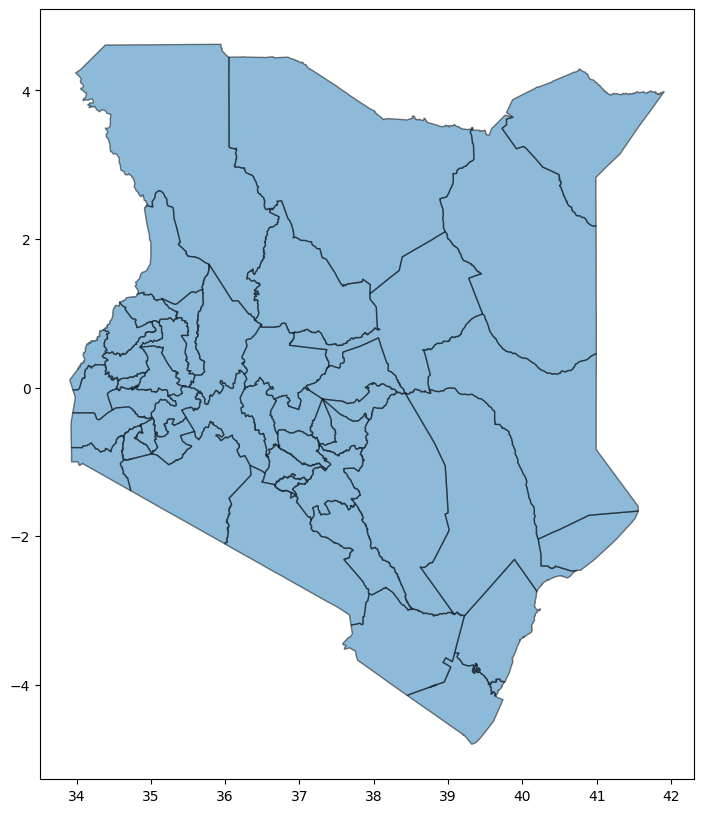

In [24]:


gdf = access.just_plot_counties(relation_ids)


In [25]:
individual  = df.copy()
individual['ever_schooled'].isna().sum()
individual  =individual.dropna(subset=['ever_schooled'])
individual['ever_schooled'] = individual['ever_schooled'].map({1: True, 0: False, 'Yes': True, 'No': False})


In [26]:
dist = individual.groupby(['county', 'ever_schooled']).size().reset_index(name='count')
dist.head(20)

/tmp/ipython-input-775172337.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist = individual.groupby(['county', 'ever_schooled']).size().reset_index(name='count')


,county,ever_schooled,count
0,Mombasa,False,73
1,Mombasa,True,1232
2,Kwale,False,220
3,Kwale,True,1346
4,Kilifi,False,216
5,Kilifi,True,1259
6,Tana River,False,616
7,Tana River,True,1170
8,Lamu,False,209
9,Lamu,True,941


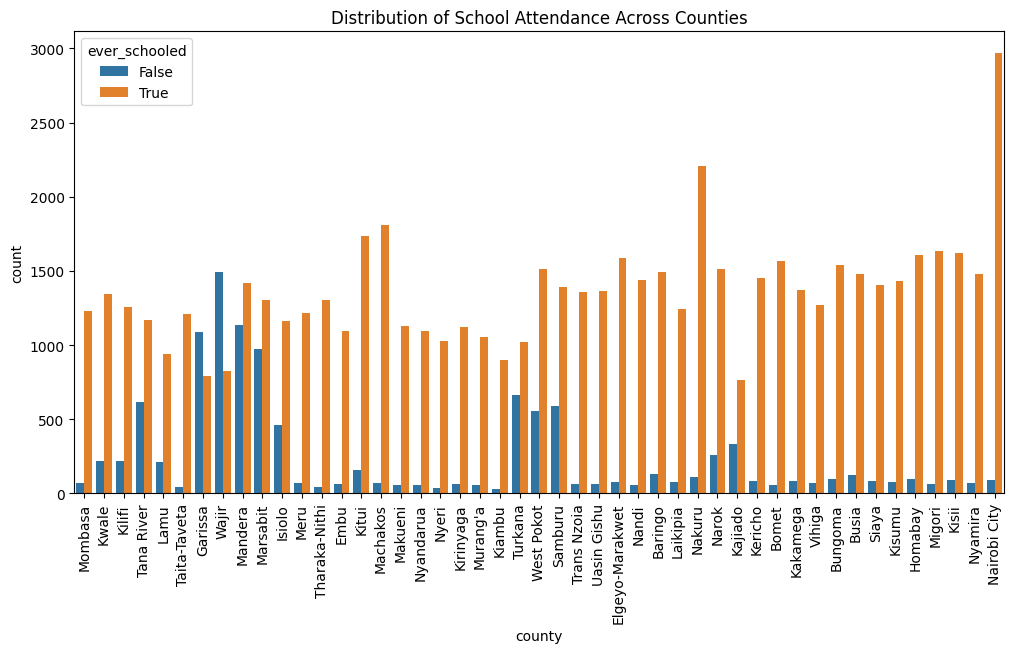

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=dist, x='county', y='count', hue='ever_schooled')
plt.xticks(rotation=90)
plt.title("Distribution of School Attendance Across Counties")
plt.show()

In [28]:
# Convert strings to proper booleans
individual['ever_schooled'] = individual['ever_schooled'].astype(str).str.strip()

# Map to True/False
individual['ever_schooled'] = individual['ever_schooled'].map({'True': True, 'False': False})
dist = (
    individual.groupby('county')['ever_schooled']
              .mean()  # mean of True/False → proportion True
              .reset_index(name='prop_schooled')
)





/tmp/ipython-input-3345403379.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  individual.groupby('county')['ever_schooled']


In [29]:
dist.head()
#print(len(dist))

,county,prop_schooled
0,Mombasa,0.944061
1,Kwale,0.859515
2,Kilifi,0.853559
3,Tana River,0.655095
4,Lamu,0.818261


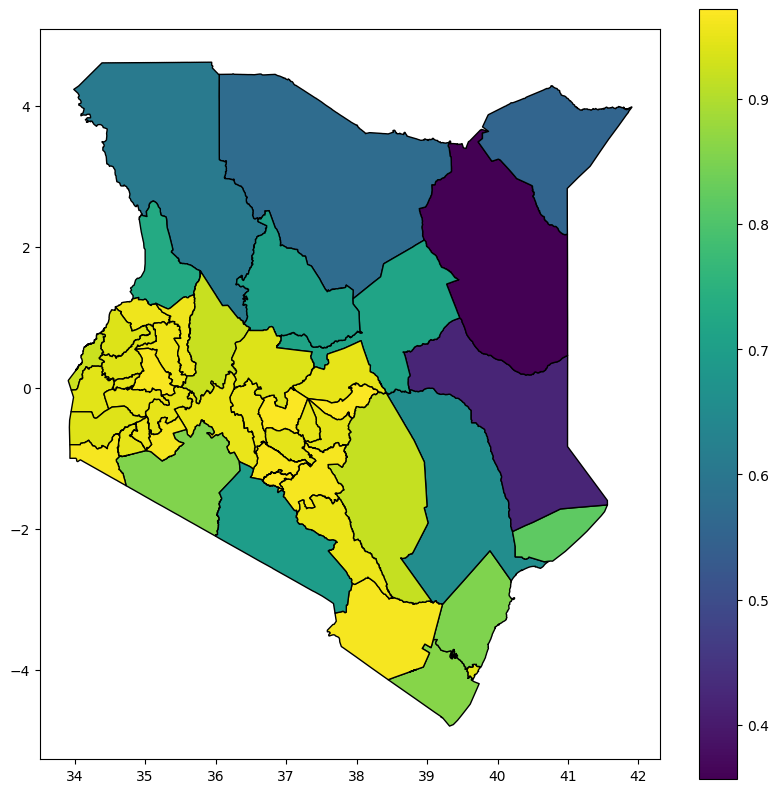

In [39]:
prop = dist['prop_schooled']
#display(prop)
#print(prop.typ)
access.plot_counties(relation_ids,dist['prop_schooled'])

#plot_counties(relation_ids, prop)

<Axes: >

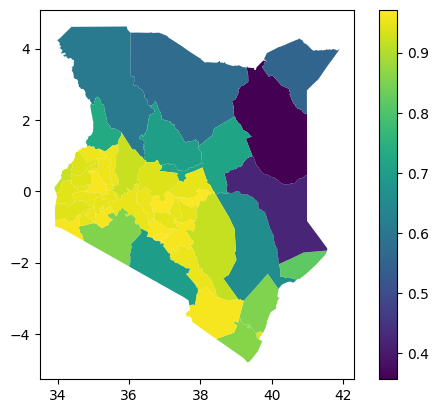

In [33]:
gdf["value"] = dist["prop_schooled"]

gdf.plot(column="value", cmap="viridis", legend=True)


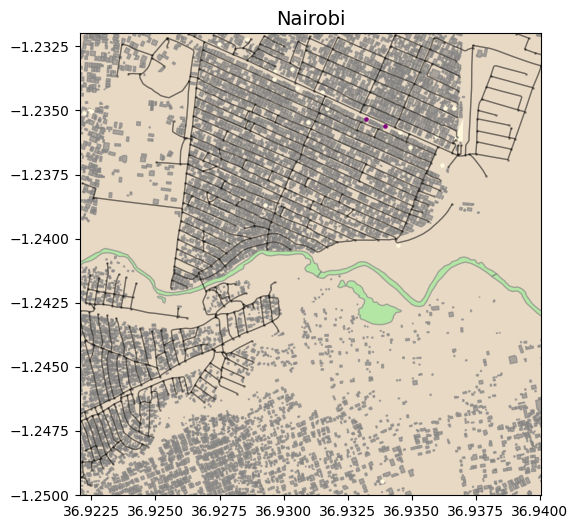

In [34]:
fynesse.assess.plot_city_map(county_list[46],-1.241,36.93105,2)

fvv







vf





v




In [36]:
# Select and rename relevant columns from the HOUSEHOLD questionnaire
df_households = []
household_df = (
    household[[
        "interview__id", "interview__key", "a01", "c01_1", "c04", "c07",
        "d01", "d17", "g01a", "g01b", "k05"
    ]].copy()
    .rename(columns={
        "interview__id": "interview_id",
        "interview__key": "interview_key",
        "a01": "county",
        "c01_1": "water_source",
        "c04": "toilet_type",
        "c07": "has_electricity",
        "d01": "num_rooms",
        "d17": "dwelling_type",
        "g01a": "dist_primary_school",
        "g01b": "dist_secondary_school",
        "k05": "monthly_rent"
    })

)



household_df.head()

,interview_id,interview_key,county,water_source,toilet_type,has_electricity,num_rooms,dwelling_type,dist_primary_school,dist_secondary_school,monthly_rent
0,8a585d4dd71641b8a1348be6cc11e121,00-00-55-14,Laikipia,PUBLIC WATER COMPANIES,Pit latrine with slab,"Yes, Soap/detergent and Water",2,Yes,500.0,500.0,NaN
1,d155c88b64de40148cda8dd079c36baa,00-01-22-52,Embu,PUBLIC WATER COMPANIES,Flush to Septic tank,"Yes, Soap/detergent and Water",1,Yes,350.0,1150.0,5000.0
2,b511ae4612704d9b9d395c901d975644,00-02-11-67,Vihiga,WATER FROM SPRING (Protected),Pit latrine with slab,No,1,Yes,800.0,900.0,NaN
3,e1ff2d92960947d8adc30f55ff666b15,00-02-70-91,Garissa,DUG WELL (Unprotected),No facility/Bush/Field,"Yes, Water Only",3,Yes,3000.0,5000.0,NaN
4,522414c7575543ddb88782491aa5e190,00-02-78-46,Embu,PUBLIC WATER COMPANIES,Flush to Piped Sewer System,No,1,No,2000.0,2000.0,4000.0


In [37]:
# Select and rename relevant columns from the INDIVIDUAL roster
individual_df = (
    individual[[
        "interview__id", "interview__key", "hhid__id","b04", "b05_years", "b10", "b11",
        "b12", "b13", "b13_1", "b13_2", "b13_3", "b13_4", "edu_attendance"
    ]].copy()
    .rename(columns={
        "interview__id": "interview_id",
        "interview__key": "interview_key",
        "hhid__id": "household_id",
        "b04": "gender",
        "b05_years": "age",
        "b10": "ever_schooled",
        "b11": "currently_schooling",
        "b12": "current_level",
        "b13": "highest_level",
        "b13_1": "distance_to_school",
        "b13_2": "mode_transport_to_school",
        "b13_3": "time_to_school",
        "b13_4": "cost_to_school",
        "edu_attendance": "education_level"
    })
)

# Create a member index within each household

print(f"Individual DataFrame shape: {df_individuals.shape}")
df_individuals.head()

KeyError: "None of [Index(['interview__id', 'interview__key', 'hhid__id', 'b04', 'b05_years',\n       'b10', 'b11', 'b12', 'b13', 'b13_1', 'b13_2', 'b13_3', 'b13_4',\n       'edu_attendance'],\n      dtype='object')] are in the [columns]"

In [ ]:
# First: make sure both household and individual dfs use the same column names
hh =[]
ind =[]
df_combined =[]
hh =
df = df.reset_index(drop=True)   # gives 0,1,2,3,...




In [ ]:
# Look at one household
#df_combined.loc[("8a585d4dd71641b8a1348be6cc11e121", "00-00-55-14")]
df_combined.head()

In [ ]:
print(len(df_combined))


In [ ]:
import pandas as pd

# Step 1: Create basic aggregation - convert all individual data to lists per household
individual_aggregated = individual_df.groupby('interview_key').agg(
    lambda x: list(x)
).reset_index()

# Step 2: Add household size
individual_aggregated['household_size'] = individual_df.groupby('interview_key').size().values

# Step 3: Merge with household data
final_df = []
final_df = household_df.merge(
    individual_aggregated,
    on='interview_key',
    how='left'
)



In [ ]:
final_df.head()
